# CIFAR-10

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, ReLU, Activation
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession



config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import pickle

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [6]:
idx = np.argsort(y_train)
x_train = x_train[idx]
y_train = y_train[idx]

In [7]:
idxs_per_class = [np.squeeze(np.argwhere(y_train == i)) for i in range(10)]

train_size_per_class = 200
val_size_per_class = 5000

x_train_small = []
y_train_small = []

x_val = []
y_val = []

np.random.seed(666)

for i in range(10):
    perm_idx = np.random.permutation(len(idxs_per_class[i]))
    x_train_small.extend(x_train[idxs_per_class[i][perm_idx[:train_size_per_class]]])
    x_val.extend(x_train[idxs_per_class[i][perm_idx[train_size_per_class:train_size_per_class + val_size_per_class]]])
    y_train_small.extend(y_train[idxs_per_class[i][perm_idx[:train_size_per_class]]])
    y_val.extend(y_train[idxs_per_class[i][perm_idx[train_size_per_class:train_size_per_class + val_size_per_class]]])
    
x_train_small = np.array(x_train_small)
x_val = np.array(x_val)


In [8]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
            featurewise_center = True,
            featurewise_std_normalization = True,
            horizontal_flip=True,)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True)

In [9]:
train_datagen.fit(x_train_small)
val_datagen.mean = train_datagen.mean
val_datagen.std = train_datagen.std

In [10]:
train_gen = train_datagen.flow(x_train_small, to_categorical(y_train_small), batch_size=32)
val_gen = val_datagen.flow(x_val, to_categorical(y_val), shuffle=False, batch_size=32)

In [11]:
to_categorical(y_train_small).shape

(2000, 10)

In [12]:
np.unique(y_val)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [13]:
from tensorflow.keras.layers import *

from tensorflow.keras.regularizers import l2

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    logits = Dense(num_classes, kernel_initializer='he_normal')(y)
    outputs = Activation('softmax')(logits)

    # Instantiate model.
    model = tf.keras.models.Model(inputs=inputs, outputs=logits)
    model_with_softmax = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model, model_with_softmax

In [14]:
tf.keras.backend.clear_session()

model, model_with_softmax = resnet_v1([32,32,3], 20)
init_weight_copy = model.get_weights()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization_v2[0][0]     
______________________________________________________________________________________________

In [52]:
# Setup model
tf.keras.backend.clear_session()


# class CNNBlock(tf.keras.Model):

#     def __init__(self):
#         super(MLPBlock, self).__init__()
#         self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
#         self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
#         self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
#         self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
#         self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
#         self.flatten = tf.keras.layers.Flatten()
#         self.dense1 = tf.keras.layers.Dense(64, activation='relu')
#         self.dense2 = tf.keras.layers.Dense(10)
#         self.softmax = tf.keras.layers.Activation('softmax')
        
#         self.logits = None
#         self.probs = None

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = self.flatten(x)
#         x = self.dense1(x)
#         self.logits = self.dense2(x)
#         self.probs = self.softmax(x)
#         return self.probs


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10))
# model.add(tf.keras.layers.Activation('softmax'))

model_with_softmax = tf.keras.models.Model(model.input, tf.keras.layers.Activation('softmax')(model.output))

init_weight_copy = model.get_weights()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [17]:
model_with_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
@tf.function()
def double_back(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            p = model_with_softmax(x)
#             print(p)
            error = tf.losses.categorical_crossentropy(y, p)
        grad_Lx = tape2.gradient(error, x)
#         print(error)
        loss = error + lamb * tf.reduce_mean(tf.reduce_sum(grad_Lx ** 2, axis=[1,2,3]))
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_Lx

@tf.function()
def JacReg(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            p = model_with_softmax(x)
            error = tf.losses.categorical_crossentropy(y, p)
        grad_fx = tape2.batch_jacobian(p, x)
        loss = error + lamb * tf.reduce_sum(grad_fx ** 2) / tf.cast(tf.shape(y)[0], tf.float32)
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_fx

@tf.function()
def FobReg(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            logit = model(x)
            error = tf.losses.categorical_crossentropy(y, tf.nn.softmax(logit))
        grad_gx = tape2.batch_jacobian(logit, x)
        loss = error + lamb * tf.reduce_sum(grad_gx ** 2) / tf.cast(tf.shape(y)[0], tf.float32)
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_gx

@tf.function()
def MyFobReg1(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            logit = model(x)
            p = tf.nn.softmax(logit)
            error = tf.losses.categorical_crossentropy(y, p)
            
        # tr(g_x^T L^2g g_x)
        grad_gx = tf.reshape(tape2.gradient(logit, x), [-1,10,32*32*3])
        L_2g = tf.stop_gradient(tf.linalg.diag(p) - tf.matmul(p, tf.transpose(p)))
        tmp = tf.matmul(tf.transpose(grad_gx, [0,2,1]), L_2g)
        # To increase efficiency
        penalty = tf.reduce_sum(tmp * tf.transpose(grad_gx)) / tf.cast(tf.shape(y)[0], tf.float32)
        
        
        loss = error + lamb * penalty
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_gx

@tf.function()
def MyFobReg2(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            logit = model(x)
            p = tf.nn.softmax(logit)
            error = tf.losses.categorical_crossentropy(y, p)
            
        # tr(g_x^T L^2g g_x)
#         grad_gx = tf.reshape(tape2.gradient(logit, x), [-1,10,28*28*1])
        grad_gx = tape2.batch_jacobian(logit, x)
        grad_gx = tf.reshape(grad_gx, [-1,10,32*32*3])
        
        L_2g = tf.linalg.diag(p) - tf.matmul(tf.reshape(p,[-1,10,1]) , tf.reshape(p,[-1,1,10]))
        tmp = tf.matmul(tf.transpose(grad_gx, perm=[0,2,1]), L_2g)
        # To increase efficiency
        penalty = tf.reduce_sum(tmp * tf.transpose(grad_gx, perm=[0,2,1])) / tf.cast(tf.shape(y)[0], tf.float32)
        
        
        loss = error + lamb * penalty
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_gx



In [21]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.]
loss_hist_db = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_db[reg] = {
        'train':[],
        'val':[],
        'acc':[],
        'final_val':None,
        'final_acc':None
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = double_back(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_db[reg]['train'].append(result_train[0])
        loss_hist_db[reg]['val'].append(result_val[0])
        loss_hist_db[reg]['acc'].append(result_val[1])
        print(result_val)
        
    loss_hist_db[reg]['final_val'] = result_val[0]
    loss_hist_db[reg]['final_acc'] = result_val[1]
    
    
                
            
    
#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_train)
#         double_back(input_X, )
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_test)
#         eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

#         eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
#         loss_hist_db[reg]['train'].append(loss)
#         loss_hist_db[reg]['val'].append(eval_loss)odel(x)
#             error = tf.losses.categorical_crossentropy(p, y)
#         loss_hist_db[reg]['acc'].append(eval_acc)


#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2

#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
#             print(f'evaluation acc: epoch {i} = {eval_acc}')



[0.7514844224123869, 0.74538]
[0.5807980518813125, 0.79178]
[0.46431410024943626, 0.84558]
[0.367056813135133, 0.87544]
[0.34657571852276897, 0.88448]
[0.29260851869118887, 0.90504]
[0.307086669230954, 0.89686]
[0.2757542850817622, 0.91136]
[0.2424867215369109, 0.92152]
[0.2042116889894254, 0.9359]
[0.189906374341987, 0.9402]
[0.21433049672052637, 0.931]
[0.2093347702442769, 0.9304]
[0.17024277637445118, 0.94656]
[0.20525007656229016, 0.9359]
[0.1869293166658101, 0.94296]
[0.24420915506538826, 0.92446]
[0.19133295568381928, 0.9405]
[0.21523460530805286, 0.93454]
[0.1953792363792236, 0.94162]
[0.19481602175290394, 0.94132]
[0.23643072950304597, 0.93086]
[0.1634053697512152, 0.95142]
[0.16919489190373674, 0.95194]
[0.21886551966217002, 0.93758]
[0.1623672173872407, 0.95314]
[0.1812023196306528, 0.94678]
[0.16435931653013156, 0.95234]
[0.1601523989859953, 0.95092]
[0.16606922884347813, 0.9534]
[0.1717549011212406, 0.95124]
[0.16241362926028874, 0.95458]
[0.16784193079999213, 0.95386]
[0.2

In [66]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.]
loss_hist_jac = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_jac[reg] = {
        'train':[],
        'val':[],
        'acc':[],
        'final_val':None,
        'final_acc':None
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = JacReg(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_jac[reg]['train'].append(result_train[0])
        loss_hist_jac[reg]['val'].append(result_val[0])
        loss_hist_jac[reg]['acc'].append(result_val[1])
        print(result_val)
        
    loss_hist_jac[reg]['final_val'] = result_val[0]
    loss_hist_jac[reg]['final_acc'] = result_val[1]
    
    
                
            
    
#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_train)
#         double_back(input_X, )
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_test)
#         eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

#         eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
#         loss_hist_jac[reg]['train'].append(loss)
#         loss_hist_jac[reg]['val'].append(eval_loss)odel(x)
#             error = tf.losses.categorical_crossentropy(p, y)
#         loss_hist_jac[reg]['acc'].append(eval_acc)


#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2

#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
#             print(f'evaluation acc: epoch {i} = {eval_acc}')



[1.9618212252457936, 0.28416666]


KeyboardInterrupt: 

In [67]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.]
loss_hist_fob = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_fob[reg] = {
        'train':[],
        'val':[],
        'acc':[],
        'final_val':None,
        'final_acc':None
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = FobReg(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_fob[reg]['train'].append(result_train[0])
        loss_hist_fob[reg]['val'].append(result_val[0])
        loss_hist_fob[reg]['acc'].append(result_val[1])
        print(result_val)
        
    loss_hist_fob[reg]['final_val'] = result_val[0]
    loss_hist_fob[reg]['final_acc'] = result_val[1]
    
    
                
            
    
#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_train)
#         double_back(input_X, )
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_test)
#         eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

#         eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
#         loss_hist_fob[reg]['train'].append(loss)
#         loss_hist_fob[reg]['val'].append(eval_loss)odel(x)
#             error = tf.losses.categorical_crossentropy(p, y)
#         loss_hist_fob[reg]['acc'].append(eval_acc)


#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2

#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
#             print(f'evaluation acc: epoch {i} = {eval_acc}')



[2.063711339155833, 0.211875]


KeyboardInterrupt: 

In [ ]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.]
loss_hist_myfob = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_myfob[reg] = {
        'train':[],
        'val':[],
        'acc':[],
        'final_val':None,
        'final_acc':None
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = MyFobReg2(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_myfob[reg]['train'].append(result_train[0])
        loss_hist_myfob[reg]['val'].append(result_val[0])
        loss_hist_myfob[reg]['acc'].append(result_val[1])
        print(result_val)
        
    loss_hist_myfob[reg]['final_val'] = result_val[0]
    loss_hist_myfob[reg]['final_acc'] = result_val[1]
    
    
                
            
    
#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_train)
#         double_back(input_X, )
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_test)
#         eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

#         eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
#         loss_hist_myfob[reg]['train'].append(loss)
#         loss_hist_myfob[reg]['val'].append(eval_loss)odel(x)
#             error = tf.losses.categorical_crossentropy(p, y)
#         loss_hist_myfob[reg]['acc'].append(eval_acc)


#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2

#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
#             print(f'evaluation acc: epoch {i} = {eval_acc}')



[2.0195764886538186, 0.26795834]
[1.8629297382831573, 0.325375]
[1.6881158035993575, 0.38272917]
[1.6593445909023286, 0.39675]
[1.5922072292963663, 0.4318125]
[1.6248784741560618, 0.41660416]
[1.6237745058933895, 0.431125]
[1.6436611970265707, 0.45297918]
[1.7607451989253362, 0.465625]
[1.8157031290531158, 0.47572917]
[2.0075305102268857, 0.44004166]
[2.0647948456605274, 0.46970832]
[2.1958585358460745, 0.47960415]
[2.5195901691516243, 0.46466666]
[2.448451618552208, 0.46860418]
[2.9046570038398105, 0.44791666]
[3.103213348229726, 0.4460625]
[2.5733840484221777, 0.47327083]
[3.1134565169413886, 0.43497917]
[3.517014883776506, 0.46033335]
[3.5535446908871333, 0.44110417]
[3.7008742869297664, 0.44589582]
[4.569968689719836, 0.43002084]
[3.386666964550813, 0.44008332]
[5.46249107380708, 0.40172917]
[3.7018991884390515, 0.4499375]
[4.088863689104716, 0.46510416]
[4.597030734499295, 0.447375]
[4.42718410730362, 0.43383333]
[4.616430694619814, 0.43254167]
[4.1918539448579155, 0.4655625]
[4.6

In [36]:
with open('data/loss_hist_db.pk', 'wb') as f:
    pickle.dump(loss_hist_db, f)
    
with open('data/loss_hist_jac.pk', 'wb') as f:
    pickle.dump(loss_hist_jac, f)
    
with open('data/loss_hist_fob.pk', 'wb') as f:
    pickle.dump(loss_hist_fob, f)
    
with open('data/loss_hist_myfob.pk', 'wb') as f:
    pickle.dump(loss_hist_myfob, f)

In [55]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.003]
loss_hist_NI = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_NI[reg] = {
        'train':[],
        'val':[],
        'acc':[]
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
#             print(x_batch.shape)
            x_batch = x_batch + reg * np.random.normal(size=x_batch.shape)
#             print( np.random.normal(x_batch.shape).shape)
#             print(x_batch.shape)
            
            model_with_softmax.fit(x_batch, y_batch, verbose=0)
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_NI[reg]['train'] = result_train[0]
        loss_hist_NI[reg]['val'] = result_val[0]
        loss_hist_NI[reg]['acc'] = result_val[1]
        print(result_val)
                


[2.106097968180974, 0.24252084]
[2.0203809775511425, 0.27422917]
[1.9870908951759338, 0.29783332]
[1.911327012181282, 0.31166667]
[1.9080909762382507, 0.30677083]
[1.8100877270301183, 0.34991667]
[1.849988187511762, 0.32610416]
[1.9683785753647487, 0.30958334]
[1.9816244787772497, 0.31308332]
[1.8045279125769933, 0.34745833]
[1.9022431813081107, 0.32133332]
[1.8675002650419872, 0.3535]
[1.7810418569644293, 0.36441666]
[1.7961334213415783, 0.3601875]
[1.9150441690286, 0.337125]
[1.8165219362576803, 0.3700625]
[1.8507948751052221, 0.37335417]
[1.8840285965601604, 0.37377083]
[1.9802389848629633, 0.34358335]
[1.837437073548635, 0.37564585]
[2.165802494764328, 0.335375]
[1.8842155937751135, 0.375625]
[1.96427153189977, 0.36625]
[2.0398232137759527, 0.367625]
[2.0452545282443366, 0.35729167]
[2.2825366760889687, 0.34270832]
[2.201178395609061, 0.34110418]
[2.4580294144153596, 0.34370834]
[2.2895432178576787, 0.36666667]
[2.4137112384637196, 0.33708334]
[2.545113268772761, 0.34322917]
[2.368

In [27]:
for reg in [0.]:
    
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model_with_softmax.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    for i in range(50):
        batches = 0
        for x_batch, y_batch in train_gen:
            
            model_with_softmax.fit(x_batch, y_batch, verbose=0)
            
            batches += 1 
            if batches > len(x_train_small) / 32:
                break
                
        result_val = model_with_softmax.evaluate_generator(val_gen)
                
        print(result_val)

[2.4414307491381964, 0.19885416]
[3.4419710866808892, 0.14520833]
[2.047836032629013, 0.34260416]
[2.428678876519203, 0.28616667]
[2.1205303042729695, 0.3560625]
[2.555783358534177, 0.32610416]
[2.2145035400986672, 0.33810416]
[2.940599582115809, 0.26220834]
[2.2750795789957046, 0.3665]
[2.8433411510388056, 0.34477082]
[3.3280915940701963, 0.30960417]
[2.4488372639020284, 0.3528125]
[3.2162661468585334, 0.330875]
[3.699977999786536, 0.3055625]
[3.217338627119859, 0.3269375]
[2.090622312883536, 0.45604166]
[3.96729026500384, 0.27535418]
[3.3027717119256654, 0.32675]
[2.958819923440615, 0.36725]
[3.058399925192197, 0.37502083]
[2.4329723086754482, 0.4294375]
[3.0177890967528027, 0.3623125]
[3.590615126957496, 0.35289583]
[3.1773837256034216, 0.35670835]
[2.5646375380357105, 0.43110415]
[3.6446301850279172, 0.35497916]
[3.4554203991095225, 0.40260416]
[3.4840608004728955, 0.38516667]
[2.9363854108651477, 0.39033332]
[2.6056826537450153, 0.43360418]
[3.179251694480578, 0.39614582]
[3.11636

In [57]:
loss_hist_NI

{1.0: {'train': 0.6394061931068935, 'val': 3.2741798299153646, 'acc': 0.36425},
 0.3: {'train': 0.1254924935480905,
  'val': 3.7235487391551336,
  'acc': 0.42920834},
 0.1: {'train': 0.07736778869811031,
  'val': 3.4510874164700507,
  'acc': 0.46152082},
 0.03: {'train': 0.02291013043566001,
  'val': 3.6676993227799732,
  'acc': 0.496375},
 0.01: {'train': 0.08152185330196979,
  'val': 3.593271702627341,
  'acc': 0.48675},
 0.003: {'train': 0.05864377324986789,
  'val': 3.537496576209863,
  'acc': 0.48827082},
 0.001: {'train': 0.060851147054650244,
  'val': 3.7635636526544887,
  'acc': 0.48285416},
 0.0003: {'train': 0.0008512408909617022,
  'val': 4.0470349541107815,
  'acc': 0.49939585},
 0.0001: {'train': 0.021907051661170074,
  'val': 3.4882062957286837,
  'acc': 0.4951875},
 3e-05: {'train': 0.07887222132985554,
  'val': 3.3442864061196644,
  'acc': 0.48354167},
 1e-05: {'train': 0.12756063512689064,
  'val': 4.030890691518784,
  'acc': 0.45545834}}

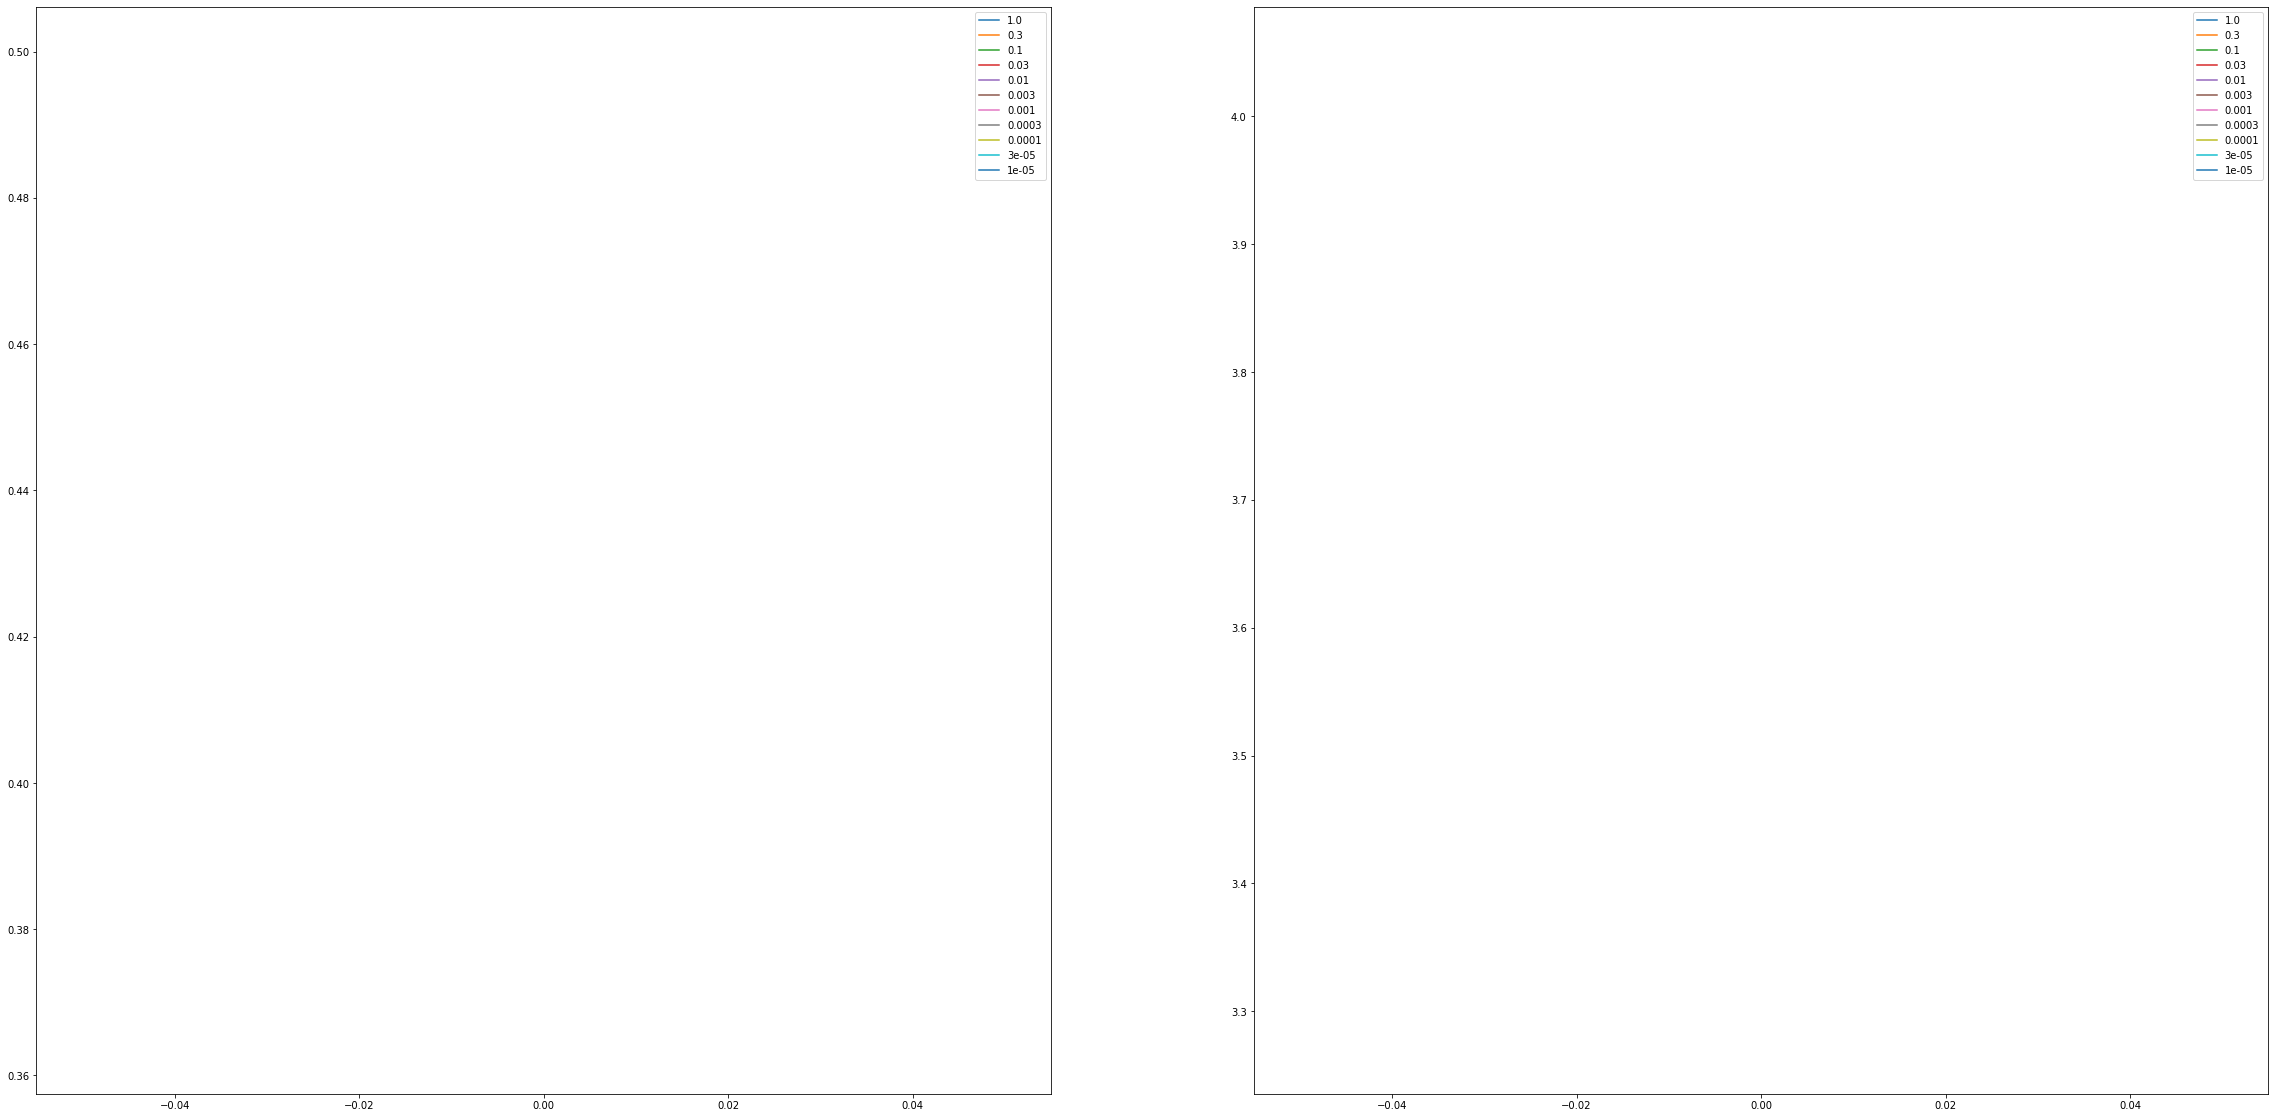

In [56]:
_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = reg_candidate
for key in reg_show:
    axes[0].plot(loss_hist_NI[key]['acc'], label=str(key))
    axes[1].plot(loss_hist_NI[key]['val'], label=str(key))

axes[0].legend()
axes[1].legend()

In [27]:
loss_hist_myfob

{1.0: {'train': 4.076283328300575, 'val': 4.5233908996634975, 'acc': 0.84364},
 0.3: {'train': 5.74310751104948, 'val': 6.200910195675702, 'acc': 0.8544},
 0.1: {'train': 3.865146759832622, 'val': 4.26400200860259, 'acc': 0.83582},
 0.03: {'train': 8.945905870861477, 'val': 9.345651721882321, 'acc': 0.74962},
 0.01: {'train': 4.418556973744657, 'val': 4.8934256101802145, 'acc': 0.78438},
 0.003: {'train': 3.879418838724849,
  'val': 4.1561557430174485,
  'acc': 0.84628},
 0.001: {'train': 0.3233450589725599,
  'val': 0.5422545323607901,
  'acc': 0.94128},
 0.0003: {'train': 3.8124386625630513,
  'val': 4.097533120076553,
  'acc': 0.84888},
 0.0001: {'train': 3.8231233394620743,
  'val': 4.0982925431782204,
  'acc': 0.84336},
 3e-05: {'train': 5.192582529392981, 'val': 5.861138069209582, 'acc': 0.8371},
 1e-05: {'train': 7.631682744101872, 'val': 8.255822636433937, 'acc': 0.75366}}

In [32]:
loss_hist_fob

{1.0: {'train': 6.479618935357957, 'val': 6.423560653897584, 'acc': 0.7593},
 0.3: {'train': 6.876419128439877, 'val': 7.243364749531413, 'acc': 0.76328},
 0.1: {'train': 4.435769674162744, 'val': 4.588832596496401, 'acc': 0.84428},
 0.03: {'train': 4.824000366150387, 'val': 6.060022825664626, 'acc': 0.76614},
 0.01: {'train': 6.971433393538944, 'val': 7.085428709754026, 'acc': 0.74926},
 0.003: {'train': 15.941330270161705,
  'val': 16.506002319521567,
  'acc': 0.5778},
 0.001: {'train': 3.537570909848289, 'val': 4.077963299225447, 'acc': 0.8385},
 0.0003: {'train': 0.4498931951021474,
  'val': 0.8449704319575007,
  'acc': 0.93038},
 0.0001: {'train': 11.076466817704459,
  'val': 11.195109361919643,
  'acc': 0.66034}}

In [30]:
with open('data/loss_hist_jac.pk', 'rb') as f:    
    loss_hist_jac = pickle.load(f)

In [31]:
loss_hist_jac

{1.0: {'train': 3.9589602594877262, 'val': 4.1033336863767715, 'acc': 0.85704},
 0.3: {'train': 4.1565993833134725, 'val': 4.302544057634495, 'acc': 0.84602},
 0.1: {'train': 0.3492595686152364, 'val': 0.8332069805602897, 'acc': 0.91876},
 0.03: {'train': 0.3387333083301778, 'val': 0.5326936996824719, 'acc': 0.9421},
 0.01: {'train': 7.51676230771201, 'val': 7.316841843875594, 'acc': 0.7596},
 0.003: {'train': 4.810869755252959, 'val': 5.019160560687819, 'acc': 0.84654},
 0.001: {'train': 5.3654166313194835,
  'val': 5.644412577660888,
  'acc': 0.85192},
 0.0003: {'train': 4.315937372177667,
  'val': 4.519585442373058,
  'acc': 0.84726},
 0.0001: {'train': 5.88105757463546, 'val': 6.319257965112039, 'acc': 0.85536}}

In [33]:
with open('data/loss_hist_db.pk', 'rb') as f:    
    loss_hist_db = pickle.load(f)

In [28]:
{key:loss_hist_db[key]['final_acc'] for key in loss_hist_db}

{1.0: 0.94258,
 0.3: 0.9558,
 0.1: 0.9526,
 0.03: 0.95136,
 0.01: 0.95064,
 0.003: 0.9537,
 0.001: 0.9535,
 0.0003: 0.95202,
 0.0001: 0.9553,
 3e-05: 0.95182,
 1e-05: 0.9529}

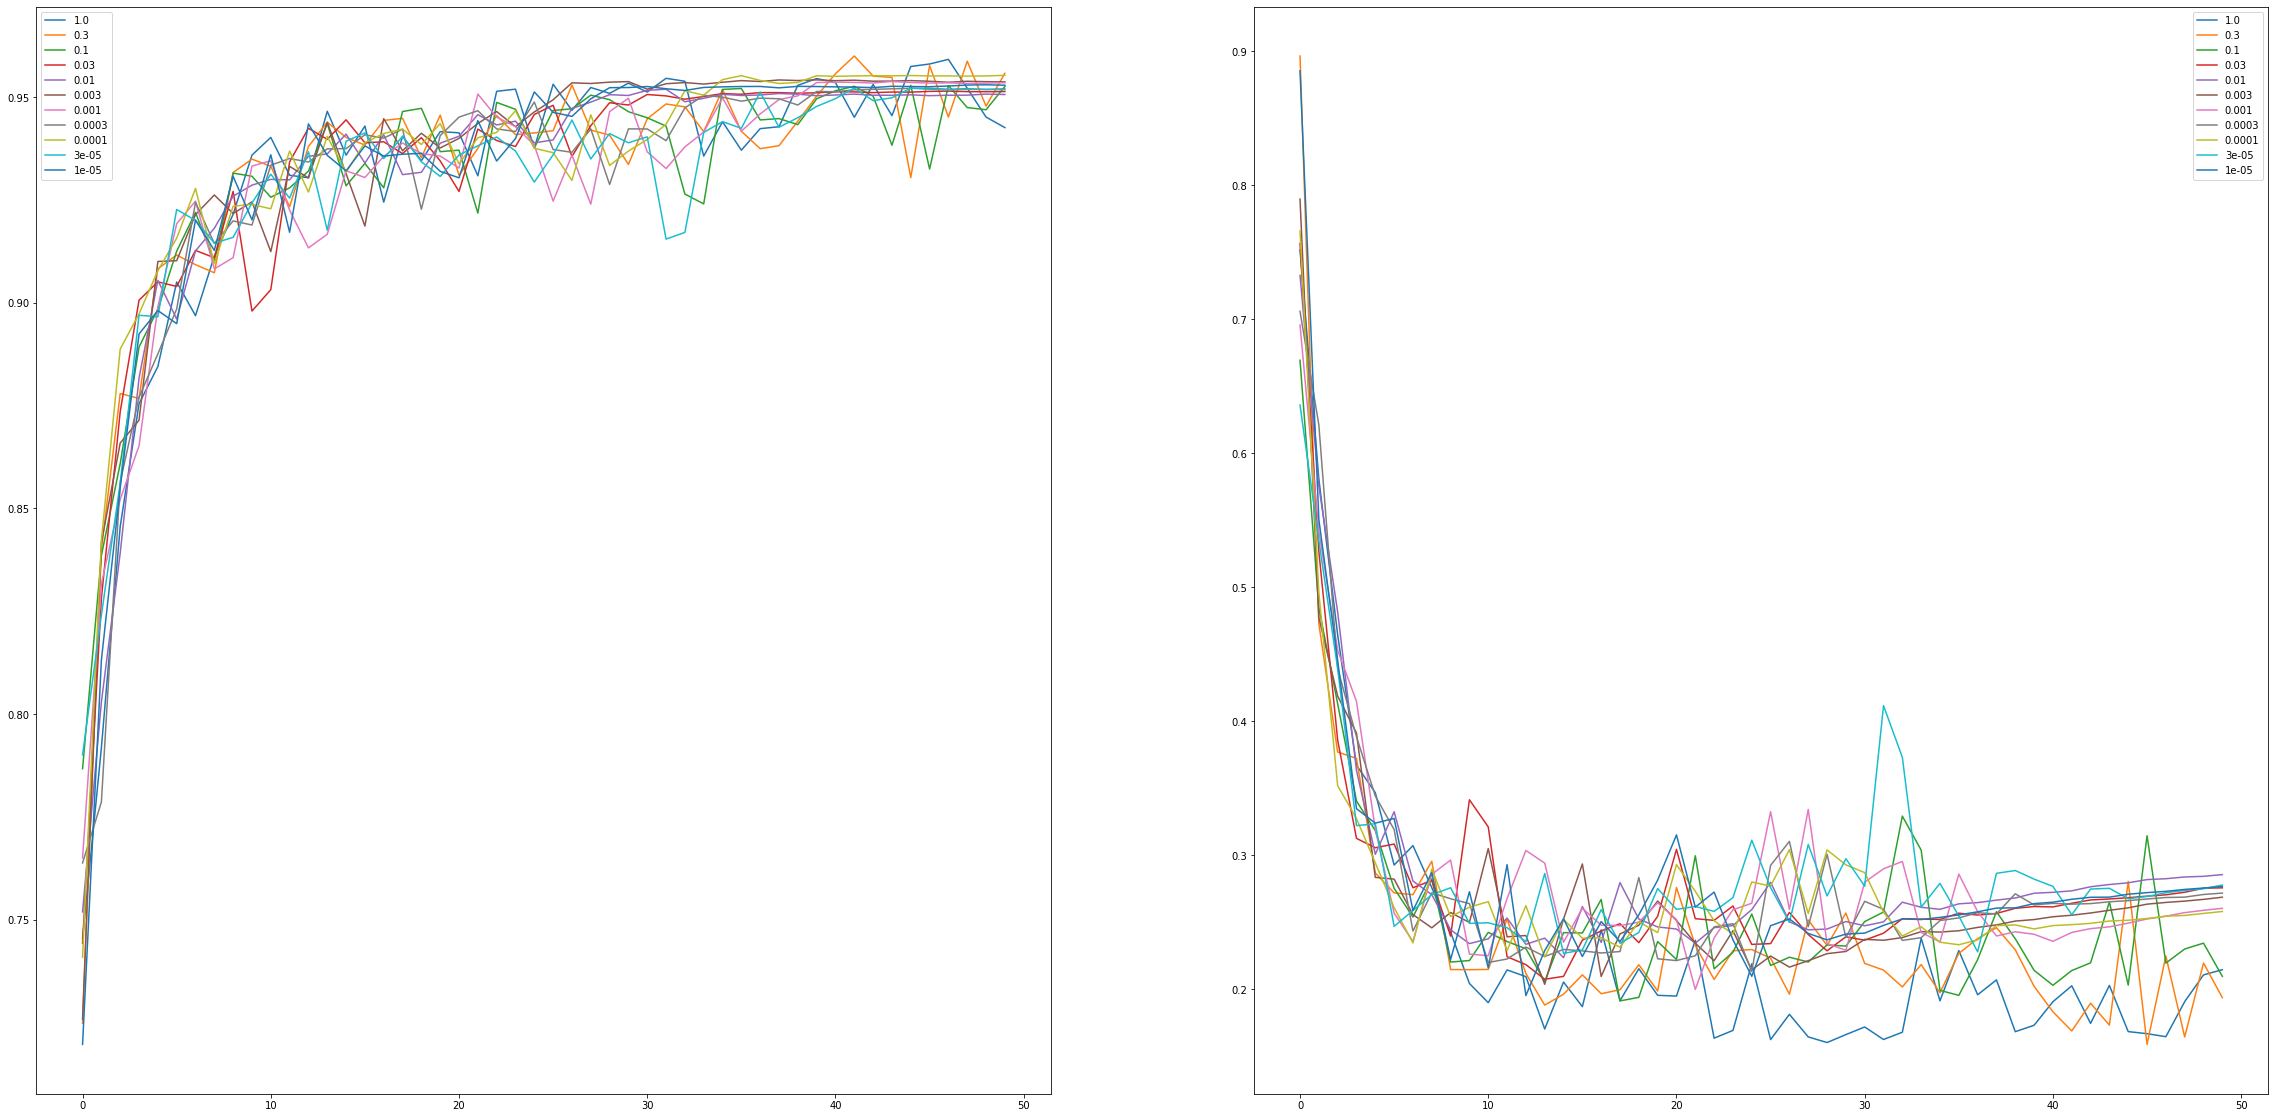

In [31]:
_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = reg_candidate
for key in reg_show:
    axes[0].plot(loss_hist_db[key]['acc'], label=str(key))
    axes[1].plot(loss_hist_db[key]['val'], label=str(key))

axes[0].legend()
axes[1].legend()

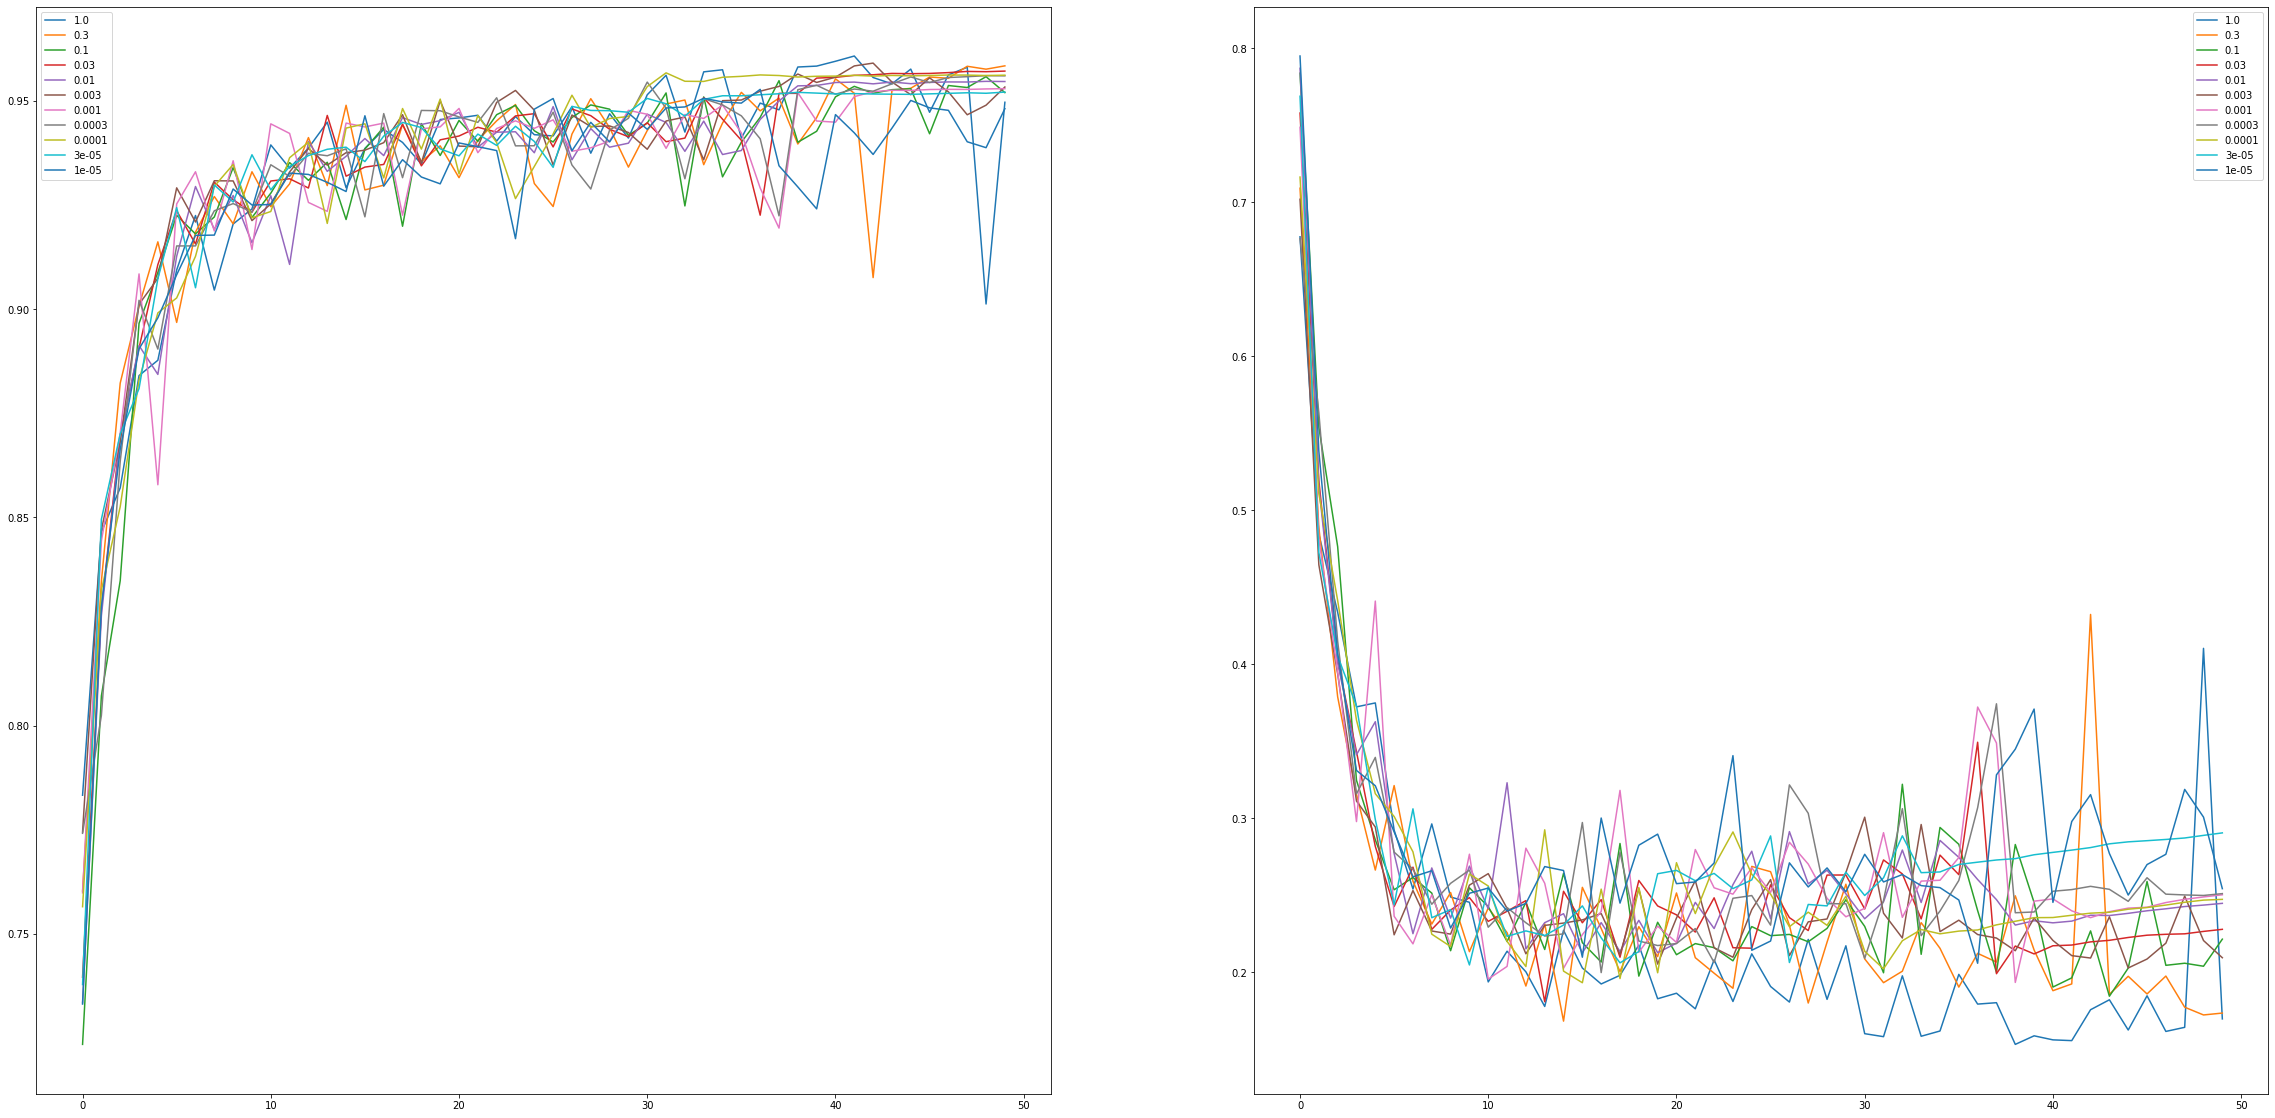

In [32]:
_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = reg_candidate
for key in reg_show:
    axes[0].plot(loss_hist_jac[key]['acc'], label=str(key))
    axes[1].plot(loss_hist_jac[key]['val'], label=str(key))

axes[0].legend()
axes[1].legend()

In [34]:


epochs = 100
batch_size = 32

x_in = tf.constant(1.)

for reg in [1.]:
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = JacReg(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)

        print(result_val)


[0.7597585282814633, 0.7355]
[0.4583255485181654, 0.84848]
[0.3883294624980165, 0.86936]
[0.3414040661321015, 0.88766]
[0.2916585783575741, 0.907]
[0.2751329623482125, 0.91404]
[0.2697225581179477, 0.91236]
[0.23012677718446098, 0.92866]
[0.27299733266892223, 0.91246]
[0.19905828162896674, 0.93916]
[0.2434152844590062, 0.92922]
[0.24243788935280727, 0.92988]
[0.19358735924028933, 0.94596]
[0.24523937366225462, 0.9332]
[0.23848662346666136, 0.93264]
[0.21118422148910057, 0.94346]
[0.23737031044674775, 0.9396]
[0.19635014454941976, 0.94904]
[0.28096178043617687, 0.93526]
[0.25853188612744094, 0.93264]
[0.20329173175760365, 0.9511]
[0.2101357868181872, 0.9505]
[0.2234166946484366, 0.9459]
[0.21652702379448638, 0.9483]
[0.2252704129295034, 0.95068]
[0.23352393744982775, 0.94966]
[0.2203644583725338, 0.9503]
[0.2813378187638498, 0.9376]
[0.30068193553861905, 0.933]
[0.2745226742030394, 0.93628]
[0.2264095759739857, 0.94138]
[0.23199034927198464, 0.94544]
[0.23334984026199956, 0.94918]
[0.21

In [35]:


epochs = 100
batch_size = 32

x_in = tf.constant(1.)

for reg in [1.]:
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = double_back(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)

        print(result_val)


[0.7401741034460331, 0.75028]
[0.5097405704421183, 0.83132]
[0.3992104697215799, 0.87104]
[0.355084052436907, 0.88978]
[0.3457619129854087, 0.8861]
[0.30073646425286826, 0.9038]
[0.23544760129932296, 0.92694]
[0.21798800085346504, 0.93208]
[0.2662040341394624, 0.91796]
[0.23732388451020933, 0.92552]
[0.26116063215299695, 0.92076]
[0.1924154961144883, 0.939]
[0.19004857454863655, 0.94068]
[0.1971774727227649, 0.9398]
[0.1555442068594289, 0.95182]
[0.1914599907970454, 0.94166]
[0.22323387739991457, 0.93274]
[0.22927235103998567, 0.93408]
[0.15199284202238825, 0.95314]
[0.15962670649110267, 0.95248]
[0.21487366351616485, 0.93572]
[0.1908526100854819, 0.94332]
[0.2328072226312776, 0.93214]
[0.16475180474552595, 0.95254]
[0.20133003916776346, 0.9393]
[0.19444769141510795, 0.94442]
[0.15484343970406583, 0.95492]
[0.1913755343376356, 0.9484]
[0.18892896608048435, 0.94678]
[0.1880290963563288, 0.94476]
[0.14102430014472916, 0.95878]
[0.24539443590603122, 0.9333]
[0.23298977082691708, 0.93652]


In [33]:
{key:loss_hist_jac[key]['final_acc'] for key in loss_hist_jac}

{1.0: 0.9496,
 0.3: 0.95834,
 0.1: 0.95192,
 0.03: 0.95708,
 0.01: 0.95458,
 0.003: 0.95326,
 0.001: 0.95286,
 0.0003: 0.95594,
 0.0001: 0.9561,
 3e-05: 0.95204,
 1e-05: 0.94806}

In [41]:
coef = {
    'db':0.003,
    'fob':0.0003,
    'myfob':0.001,
    'jac':0.03,
    'NI':0.003
}

In [38]:
np.save('data/init_weight_mnist', init_weight_copy)

In [40]:
np.load('data/init_weight_mnist.npy', allow_pickle=True)

array([array([[[[ 0.03879467,  0.04180132,  0.02118748, -0.07963803,
          -0.04738054, -0.09441105, -0.04570386,  0.04850742,
          -0.13362142, -0.09165411,  0.07136966, -0.03671246,
           0.02902691,  0.07039627, -0.12564786,  0.14126672,
          -0.06547153,  0.05867364,  0.11773531,  0.04220489,
           0.0576845 , -0.08650757,  0.1310951 ,  0.00494756,
          -0.03625003,  0.12258859,  0.09751426, -0.04335266,
          -0.10622896, -0.08249158,  0.12968756, -0.10683317]],

        [[-0.10766605,  0.03153373,  0.02195324, -0.06700226,
           0.07947798,  0.06466343,  0.08137083,  0.11936675,
          -0.08888806, -0.07786494,  0.10770838,  0.08085886,
           0.01655532,  0.05050474, -0.085133  ,  0.03890687,
          -0.05038062, -0.08150895, -0.03034618, -0.11459313,
           0.03289554, -0.02335312, -0.1061966 , -0.09142144,
          -0.00140271,  0.10314016, -0.10909945,  0.05135497,
           0.06543493, -0.07056212,  0.1263928 , -0.12043236